In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.stats import mannwhitneyu
from tueplots import bundles, figsizes

plt.rcParams.update(bundles.icml2022()) 
plt.rcParams.update(figsizes.icml2022_half())
plt.rcParams["text.usetex"] = True

In [12]:
# Define WHO countries by region
who_countries = {
    "AFR": ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cape Verde", "Cabo Verde", "Central African Republic", "Chad", "Comoros", "Ivory Coast", "Democratic Republic of the Congo", "Equatorial Guinea", "Eritrea", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mozambique", "Namibia", "Niger", "Nigeria", "Republic of the Congo", "Rwanda", "São Tomé and Príncipe", "Senegal", "Seychelles", "Sierra Leone", "South Africa", "South Sudan", "Eswatini", "Togo", "Uganda", "Tanzania", "Zambia", "Zimbabwe"],
    "AMR": ["Peru", "Paraguay", "Saint Kitts and Nevis", "Antigua and Barbuda", "Argentina", "Bahamas", "Barbados", "Belize", "Bolivia", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Grenada", "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Saint Lucia", "Saint Vincent and the Grenadines", "Suriname", "Trinidad and Tobago", "the United States of America", "Uruguay", "Venezuela"],
    "SEAR": ["Bangladesh", "Bhutan", "Democratic People's Republic of Korea", "India", "Maldives", "Myanmar", "Nepal", "Sri Lanka", "Thailand", "Timor-Leste"],
    "EUR": ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Israel", "Italy", "Kazakhstan", "Kyrgyzstan", "Latvia", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Tajikistan", "Turkey", "Turkmenistan", "Ukraine", "United Kingdom", "Uzbekistan"],
    "EMR": ["Libya", "Afghanistan", "Bahrain", "Djibouti", "Egypt", "Iran", "Iraq", "Jordan", "Kuwait", "Israel", "Oman", "Pakistan", "Qatar", "Saudi Arabia", "Somalia", "Sudan", "Syria", "Tunisia", "United Arab Emirates", "Yemen", "Morocco"],
    "WPR": ["Australia", "Brunei", "Cambodia", "China", "Cook Islands", "Fiji", "Indonesia", "Japan", "Kiribati", "Laos", "Malaysia", "Marshall Islands", "Micronesia", "Mongolia", "Nauru", "New Zealand", "Niue", "Palau", "Papua New Guinea", "Philippines", "Samoa", "Singapore", "Solomon Islands", "South Korea", "Taiwan", "Tonga", "Tuvalu", "Vanuatu", "Vietnam"]
}

# Some countries have small variations in name, so a second dictionary accounts for that
name_recode = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Côte d'Ivoire": "Ivory Coast",
    "Czechia": "Czech Republic",
    "Lao People's Democratic Republic": "Laos",
    "Republic of Moldova": "Moldova",
    "Russian Federation": "Russia",
    "Sao Tome and Principe": "São Tomé and Príncipe",
    "Türkiye": "Turkey",
    "United States of America": "the United States of America",
    "Micronesia (Federated States of)": "Micronesia",
    "Netherlands (Kingdom of the)": "Netherlands",
    "Republic of Korea": "South Korea",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "United Republic of Tanzania": "Tanzania"
}

# Read the vaccination data
vax = pd.read_csv("who_vax_country.tsv", sep="\t")

# Subset for years 2010-2014
vax = vax[vax['YEAR'].isin(range(2010, 2015))]  # Note: range(2010, 2015) to include 2014

# Subset for specific antigen description (corrected to first dose as per comment and original cleaning procedure)
vax = vax[vax['ANTIGEN_DESCRIPTION'] == "HPV Vaccination program coverage, first dose, females"]

# Convert COVERAGE to integer
vax['COVERAGE'] = vax['COVERAGE'].astype('Int64')

# Recode the NAME column
vax['NAME'] = vax['NAME'].replace(name_recode)

# Create who_region_df
who_region_df = pd.DataFrame([
    (country, region) 
    for region, countries in who_countries.items() 
    for country in countries
], columns=['NAME', 'REGION'])

# Left join vax with who_region_df
vax = vax.merge(who_region_df, on='NAME', how='left')

# Read metadata (assuming the path is similar or adjust as needed; original had "vax_metadata.csv")
metadata = pd.read_csv("vax_metadata.csv", index_col=0)  # Adjust path if necessary

# Rename column
metadata = metadata.rename(columns={'ISO_3_CODE': 'CODE'})

# Select relevant columns from metadata
metadata_selected = metadata[['CODE', 'HPV_YEAR_INTRODUCTION', 'HPV_INT_DOSES']]

# Left join vax with metadata_selected
vax = vax.merge(metadata_selected, on='CODE', how='left')

# Update COVERAGE based on conditions
vax['COVERAGE'] = np.where(
    (vax['YEAR'] < vax['HPV_YEAR_INTRODUCTION']) | 
    (vax['HPV_INT_DOSES'] == "Not yet introduced"),
    0,
    vax['COVERAGE']
)

# Drop the HPV_YEAR_INTRODUCTION column
vax = vax.drop(columns=['HPV_YEAR_INTRODUCTION'])

# Now, group by country and calculate mean coverage (after cleaning)
vaccine_summary = vax.groupby('NAME').agg(mean_coverage_2010_2014=('COVERAGE', 'mean')).reset_index()

# Read the cancer data
country_canc = pd.read_csv("Datlit_HPV_Project_Final_Database - females-2022-cervix-uteri.tsv", sep="\t", header=0)

# Convert ASR to numeric
country_canc['ASR (World)'] = pd.to_numeric(country_canc['ASR (World)'])

# Select columns
canc_country = country_canc[['Label', 'ASR (World)']].copy()
canc_country.columns = ['NAME', 'ASR']

# Merge vaccine summary with cancer data
region_summary = pd.merge(vaccine_summary, canc_country, on='NAME', how='inner')

# homogenize names (already done above, but ensure consistency)
region_summary['NAME'] = region_summary['NAME'].replace(name_recode)

# Create WHO lookup DataFrame
who_lookup = pd.DataFrame([(country, region) for region, countries in who_countries.items() for country in countries], columns=['NAME', 'WHO_REGION'])

# Merge with region summary
region_summary = pd.merge(region_summary, who_lookup, on='NAME', how='left', validate='many_to_many')

# Replace NA with 0
region_summary['mean_coverage_2010_2014'] = region_summary['mean_coverage_2010_2014'].fillna(0)

# Round to nearest integer and convert to Int64 (since mean can be float, and astype('Int64') fails on floats)
region_summary['mean_coverage_2010_2014'] = region_summary['mean_coverage_2010_2014'].round().astype('Int64')


In [13]:
# subset the data based on coverage
vax_1 = region_summary[region_summary["mean_coverage_2010_2014"] != 0]
vax_0 = region_summary[region_summary["mean_coverage_2010_2014"] == 0]

# perform wilcoxon test
u, p = mannwhitneyu(vax_0["ASR"], vax_1["ASR"], alternative='two-sided')
print(f"Wilcoxon p-value: {p:.3f}")

# expected value vs test value
exp = (len(vax_1)*len(vax_0))/2
print("Expected U: ", exp, "\n Wilcoxon U: ", u)

Wilcoxon p-value: 0.001
Expected U:  1596.0 
 Wilcoxon U:  2189.0


C:\Users\ettod\AppData\Local\Temp\ipykernel_8916\3227985097.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = pos[region_summary["WHO_REGION"] == region]
C:\Users\ettod\AppData\Local\Temp\ipykernel_8916\3227985097.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = pos[region_summary["WHO_REGION"] == region]
C:\Users\ettod\AppData\Local\Temp\ipykernel_8916\3227985097.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = pos[region_summary["WHO_REGION"] == region]
C:\Users\ettod\AppData\Local\Temp\ipykernel_8916\3227985097.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = pos[region_summary["WHO_REGION"] == region]
C:\Users\ettod\AppData\Local\Temp\ipykernel_8916\3227985097.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = pos[region_summary["WHO_REGION"] == region]
C:\Users\e

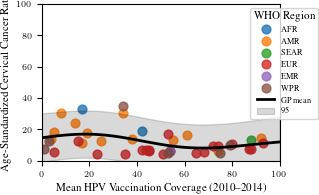

In [ ]:
who_colors = {
    "AFR": "#1b9e77",
    "AMR": "#d95f02",
    "SEAR": "#7570b3",
    "EUR": "#e7298a",
    "EMR": "#66a61e",
    "WPR": "#e6ab02"
}
pos = region_summary[region_summary["mean_coverage_2010_2014"] > 0]
X = pos['mean_coverage_2010_2014'].values.reshape(-1, 1)
y = pos['ASR'].values

kernel = RBF(length_scale=20.0) + WhiteKernel(noise_level=1.0)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)
gp.fit(X, y)

X_pred = np.linspace(0, 100, 300).reshape(-1, 1)
y_mean, y_std = gp.predict(X_pred, return_std=True)

# ------------------------------------------------------------------
# Matplotlib + tueplots figure (NEW, larger + legend outside)
# ------------------------------------------------------------------
fig, ax = plt.subplots()  # make figure bigger

for region, color in who_colors.items():
    subset = pos[region_summary["WHO_REGION"] == region]
    ax.scatter(
        subset["mean_coverage_2010_2014"],
        subset["ASR"],
        s=40,  # slightly larger points
        alpha=0.8,
        label=region
    )

# Gaussian Process regression line
ax.plot(X_pred.flatten(), y_mean, color="black", lw=2, label="GP mean")
ax.fill_between(
    X_pred.flatten(),
    y_mean - 1.96 * y_std,
    y_mean + 1.96 * y_std,
    color="black",
    alpha=0.15,
    label="95% CI"
)

# Axis labels and limits
ax.set_xlabel("Mean HPV Vaccination Coverage (2010–2014)")
ax.set_ylabel("ASR of Cervical Cancer")
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Move legend outside the plot (to the right)
ax.legend(title="WHO Region", bbox_to_anchor=(0.86, 1), loc='upper left')

#fig.tight_layout()
plt.savefig("C:\\Users\\ettod\\Tubingen_exercises\\DataL\\ASR_cov.pdf", bbox_inches="tight")
plt.show()